# 线性回归模型

MXNet 手动实现简单的线性回归模型。

线性回归是一个单层神经网络：
![image.png](img/mxnet_linear_1.png)
由于输入层并不涉及计算，按照惯例，图中神经网络的层数为1。

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

## 生成数据集

In [2]:
num_inputs = 2 # 特征数
num_examples = 1000 # 训练数据集样本数
true_w = [2, -3.4] # 真实权重，用于生成数据
true_b = 4.2 # 真实偏差，用于生成数据
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs)) 
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

In [3]:
# features 的每一行是一个长度为 2 的向量，而 labels 的每一行是一个长度为 1 的向量（标量）
features[0], labels[0]

(
 [1.1630785 0.4838046]
 <NDArray 2 @cpu(0)>, 
 [4.879625]
 <NDArray 1 @cpu(0)>)

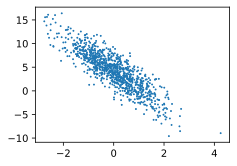

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);  # 加分号只显示图

## 读取数据

遍历数据集并不断读取小批量数据样本，data_iter 函数每次返回 batch_size（批量大小）个随机样本的特征和标签。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)  # take函数根据索引返回对应元素|

## 初始化模型参数

In [6]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

In [7]:
# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度。
w.attach_grad()
b.attach_grad()

## 定义模型

In [8]:
def linreg(X, w, b):
    return nd.dot(X, w) + b

## 定义损失函数

In [10]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法¶

以下的 sgd 函数实现了小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [12]:
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 训练模型

In [14]:
batch_size = 10 # 批量大小
lr = 0.03 # 学习率
num_epochs = 10
net = linreg # 模型函数名
loss = squared_loss # 损失函数名

In [15]:
for epoch in range(num_epochs):  # 训练模型一共需要 num_epochs 个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。
    # X 和 y 分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # l 是有关小批量 X 和 y 的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.035260
epoch 2, loss 0.000127
epoch 3, loss 0.000049
epoch 4, loss 0.000048
epoch 5, loss 0.000048
epoch 6, loss 0.000048
epoch 7, loss 0.000048
epoch 8, loss 0.000048
epoch 9, loss 0.000048
epoch 10, loss 0.000048


比较一下学到的参数和用来生成训练集的真实参数。

In [16]:
true_w, w

([2, -3.4], 
 [[ 1.9996604]
  [-3.4000878]]
 <NDArray 2x1 @cpu(0)>)

In [17]:
true_b, b

(4.2, 
 [4.200161]
 <NDArray 1 @cpu(0)>)